# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

### Contents:
- [Background](#Background)
- [Data](#Data)
- [Building own model](#Building-own-model)
- [Evaluate results](#Evaluate-results)



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img, load_img, img_to_array
from tensorflow.keras.models import Sequential,  Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Average, Input, Activation, Reshape, TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import models
from tensorflow.keras.regularizers import l2
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import AUC, Precision, Recall
pd.options.mode.chained_assignment = None  # default='warn'



**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):** 
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports. 
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* valdation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data import

**import data and get labels**

In [3]:
!unzip drive/My\ Drive/data.zip > /dev/null

In [4]:
train_path = 'data/train/'
valid_path = 'data/valid/'

In [5]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['axial', 'coronal', 'sagittal']
# diagnosis = ['abnormal','meniscus','acl']

In [6]:
def get_data(dataset_type, plane, diagnosis):
    '''this function gets the data from the original dataset'''
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path
        
#     img_path = glob(f'{go}/{plane}/*.npy')
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)
    
    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, plane_dir, label_data)

**abnormal dataset**

In [7]:
# training data
train_coronal_data, train_coronal_dir, train_ab_label = get_data('train', 'coronal', 'abnormal')
train_axial_data, train_axial_dir, train_ab_label = get_data('train', 'axial', 'abnormal')
train_sagittal_data, train_sagittal_dir, train_ab_label = get_data('train', 'sagittal', 'abnormal')

In [8]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_ab_label = get_data('valid','coronal','abnormal')
valid_axial_data, valid_axial_dir, valid_ab_label = get_data('valid','axial','abnormal')
valid_sagittal_data, valid_sagittal_dir, valid_ab_label = get_data('valid','sagittal','abnormal')

**meniscus dataset**

In [9]:
# training data
train_coronal_data, train_coronal_dir, train_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_data, train_axial_dir, train_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_data, train_sagittal_dir, train_men_label = get_data('train', 'sagittal', 'meniscus')

In [10]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_men_label = get_data('valid','coronal','meniscus')
valid_axial_data, valid_axial_dir, valid_men_label = get_data('valid','axial','meniscus')
valid_sagittal_data, valid_sagittal_dir, valid_men_label = get_data('valid','sagittal','meniscus')

In [11]:
train_coronal_data[0]

'0464.npy'

In [12]:
train_coronal_dir

'data/train//coronal'

**acl dataset**

In [13]:
# training data
train_coronal_data, train_coronal_dir, train_acl_label = get_data('train', 'coronal', 'acl')
train_axial_data, train_axial_dir, train_acl_label = get_data('train', 'axial', 'acl')
train_sagittal_data, train_sagittal_dir, train_acl_label = get_data('train', 'sagittal', 'acl')

In [14]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_acl_label = get_data('valid','coronal','acl')
valid_axial_data, valid_axial_dir, valid_acl_label = get_data('valid','axial','acl')
valid_sagittal_data, valid_sagittal_dir, valid_acl_label = get_data('valid','sagittal','acl')

The dataset contains *s* x 256 x 256 images. Since the middle image is the most useful, only the middle slide in the series is retained. 


In [15]:
def image_extraction(data, path, new_path): 
    '''this function extracts middle slide of each scan'''
    extract=[]
    new_data=[]
    for i in range(len(data)): 
        img = np.load(os.path.join(path,data[i]))
        middle_idx = int(img.shape[0]/2)
#         print(img.shape[0],middle_idx)
        img = img[(middle_idx)]
#         # reshape adapted for model (s x 256 x 256 x 1)
#         img_reshape = np.repeat(img[..., np.newaxis], 1, -1)
        img = img.reshape(256,256,1)
        extract.extend(img)
        new_data.append(np.array(extract))        
        extract.clear()
        
#     new_data.shape(1130,256,256,1) for train
    np.save(new_path, np.array(new_data))


Note that training data for all diagnoses are the same. Only labels are different.

**image extraction for training data**

In [16]:
# image extraction for 3 planes
new_path = 'data/train_transform/coronal'
image_extraction(train_coronal_data, train_coronal_dir, new_path)

In [17]:
new_path = 'data/train_transform/axial'
image_extraction(train_axial_data, train_axial_dir, new_path)

In [18]:
new_path = 'data/train_transform/sagittal'
image_extraction(train_sagittal_data, train_sagittal_dir, new_path)

In [19]:
image = np.load('data/train_transform/sagittal.npy')

In [20]:
image[0].shape

(256, 256, 1)

**extraction for validation data**

In [21]:
# image extraction for 3 planes
new_path = 'data/valid_transform/coronal'
image_extraction(valid_coronal_data, valid_coronal_dir, new_path)

In [22]:
new_path = 'data/valid_transform/axial'
image_extraction(valid_axial_data, valid_axial_dir, new_path)

In [23]:
new_path = 'data/valid_transform/sagittal'
image_extraction(valid_sagittal_data, valid_sagittal_dir, new_path)

In [24]:
image = np.load('data/valid_transform/sagittal.npy')
image.shape

(120, 256, 256, 1)

**data generation from extracted/transformed dataset**

In [25]:
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data from the extracted dataset'''
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = 'data/train_transform/'
    else:
        go = 'data/valid_transform/'
        
    plane_dir = f'{go}/{plane}.npy'
    data = np.load(plane_dir)
    
    # label_path = f'../data/{dataset_type}-{diagnosis}.csv'
    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, label_data)
    

Note that training data for all diagnoses are the same. Only labels are different. But for ease as inputs into model, data generation was done for planes and all diagnoses.

In [26]:
# meniscus
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal', 'meniscus')

# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal', 'meniscus')

In [27]:
# abnormal
# generate training input
coronal_abnormal, coronal_abnormal_label = data_gen('train', 'coronal', 'abnormal')
axial_abnormal, axial_abnormal_label = data_gen('train', 'axial', 'abnormal')
sagittal_abnormal, sagittal_abnormal_label = data_gen('train', 'sagittal', 'abnormal')

# generate validation
coronal_abnormal_val, coronal_abnormal_label_val  = data_gen('valid', 'coronal', 'abnormal')
axial_abnormal_val, axial_abnormal_label_val  = data_gen('valid', 'axial', 'abnormal')
sagittal_abnormal_val, sagittal_abnormal_label_val  = data_gen('valid', 'sagittal', 'abnormal')

In [28]:
# acl
# generate training input
coronal_acl, coronal_acl_label = data_gen('train', 'coronal', 'acl')
axial_acl, axial_acl_label = data_gen('train', 'axial', 'acl')
sagittal_acl, sagittal_acl_label = data_gen('train', 'sagittal', 'acl')

# generate validation
coronal_acl_val, coronal_acl_label_val  = data_gen('valid', 'coronal', 'acl')
axial_acl_val, axial_acl_label_val  = data_gen('valid', 'axial', 'acl')
sagittal_acl_val, sagittal_acl_label_val  = data_gen('valid', 'sagittal', 'acl')

## Building own model

The code snippet below is the first model, a simple stack of two convolution layers with a ReLU activation and followed by max-pooling layers. This is very similar to the architectures that Yann LeCun built in the 1990s for image classification (with the exception of ReLU and smaller) ([LeCun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)). In addition, three fully-connected layers were added, which ends with a single unit and a sigmoid activation, for a binary classification. 
<br>
<br> Since other pretrained models showed that there is tendency to overfit, one can either improve the data or improve the model. Since I am limited by what I can do with the dataset, a simple way is to make the model smaller. I made LeNet even smaller by reducing the number of neurons in the connected layers.
<br>
<br> BatchNormalisation layer was added because it would accelerate the training process, while offering similar classification accuracy. I did not see any 'increase' in training. This could be because BatchNormalisation is highly dependent on having a large batch size, so that it can estimate the mean and variance from just one single batch ([Summers and Dinneen 2020](https://arxiv.org/pdf/1906.03548.pdf)). And for a limited dataset like mine, BatchNormalisation with GroupNormalisation was found to have a bigger improvement, or using InstanceNormalisation would be more effective, than just using BatchNormalisation ([Summers and Dinneen 2020](https://arxiv.org/pdf/1906.03548.pdf); [Kolarik et al., 2020](https://arxiv.org/pdf/2011.11559.pdf)). However, GroupNormalisation and InstanceNormalisation were not used here (due to failure to install Tensorflow version, Tensorflow-Addon version and downgrading numpy at the same time).
<br>
<br> In any case, regularizer should NOT be added if normalisation is being used. This is because the use of both normalisation (whether it be batch normalisation, layer normalisation or weight normalisation) together with regularisation has no effect on regularising the network ([Laarhoven 2017](https://arxiv.org/pdf/1706.05350.pdf)). The effect it has is the effective learning rate (which may or may not be a bad thing). However, in such a case, one does not have control over the learning rate (which is problematic for someone with control issues, like me). BatchNormalisation can be useful since it takes the outputs from one layer and normalise it before passing them to the next layer. Furthermore, the tuning of $\gamma$ (scaling to a difference variance) has little effect since $\gamma$ has no functional value in subsequent layers. It is only most effective if used on the last layer of the network. Therefore, BatchNormalisation was used only once in the last convolution layer. 
<br>
<br> To actually control the learning rate of the optimser, sgd with a slow learning rate and momentum was selected based on using AlexNet. 

In [29]:
def build_model():
    '''this function creates and builds the cnn model'''
    model = Sequential()
    
    model.add(Conv2D(filters=6, 
                     kernel_size=(5, 5),
                     activation='relu',
                     padding='same',
                     kernel_regularizer=l2(1e-3),
                     input_shape=(256,256,1)))
    model.add(MaxPooling2D(pool_size=(2,2),
                              strides=(2,2)))

    model.add(Conv2D(filters=16, 
                     kernel_size=(5, 5), 
                     activation='relu',))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),
                              strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(32, activation='relu'
                    ,kernel_regularizer=l2(1e-3)
                   ))
    model.add(Dropout(0.4))
    
    model.add(Dense(16, activation='relu',
                    kernel_regularizer=l2(1e-3)
                   ))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    sgd = optimizers.SGD(learning_rate=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision')])
    
    return model

In [30]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 6)       156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 16)      2416      
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1

In [31]:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
def model_train(model, model_name, num_epochs, train_data, train_labels, validation_data, validation_labels):
    '''this function fits the data and saves the model and weights'''
    path_dir = '/content/drive/MyDrive' 
    path = f'{path_dir}/{model_name}/own_weights.h5'
    checkpoint_path = f'{path_dir}/{model_name}/own_model.h5'

    history = model.fit(x=train_data, y=np.array(train_labels), 
            batch_size=32, 
            validation_data=(validation_data, np.array(validation_labels)),
            epochs=num_epochs, 
            callbacks = [EarlyStopping(patience=2, monitor = 'val_loss', mode = 'min'),
                        ModelCheckpoint(filepath=checkpoint_path, monitor = 'val_loss', save_best_only=True)],
            verbose=1)

    model.save_weights(path)
    
    return model, history

Batch_size is small at 32, given that previous large numbers resulted in validation accuracy fluctuating up and down. It seems that a larger batch may result in degradation of the quality of the model, since the model lacks the ability to generalise the dataset. 
<br>
<br> The exact amount of patience will vary between models and problems. There a rule of thumb to make it 10% of number of epoch. Patience was kept at 2, since from previous models, overfitting occur very early during training (val_loss > training_loss). So it was better to stop it early, rather than have a higher value for patience. 

In [32]:
def plot_results(model):
    '''this function plots the results of the model'''
    train_loss = model.history['loss']
    test_loss = model.history['val_loss']
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    prec = model.history['precision']
    val_prec = model.history['val_precision']
    epoch_labels = model.epoch

    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)

    axes[0].plot(train_loss, label='Training Loss', color='#185fad')
    axes[0].plot(test_loss, label='Testing Loss', color='orange')

    axes[1].plot(acc, label='Training accuracy', color='blue')
    axes[1].plot(val_acc, label='Testing accuracy', color='red')
    
    axes[2].plot(prec, label='Training precision', color='blue')
    axes[2].plot(val_prec, label='Testing precision', color='red')
    
    # Set title
    axes[0].title.set_text('Training and Testing Loss by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Binary Crossentropy')
    
    axes[1].title.set_text('Training and Testing Accuracy by Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Binary Crossentropy')

    axes[2].title.set_text('Training and Testing Precision by Epoch')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Binary Crossentropy')
    
    plt.xticks(epoch_labels, epoch_labels);    
    
    axes[0].legend(fontsize=18);
    axes[1].legend(fontsize=18);
    axes[2].legend(fontsize=18);

### training for abnormal dataset

Epoch 1/10
36/36 [==============================] - 34s 63ms/step - loss: 0.8768 - accuracy: 0.5956 - precision: 0.7938 - val_loss: 0.7652 - val_accuracy: 0.7667 - val_precision: 0.7863
Epoch 2/10
36/36 [==============================] - 2s 43ms/step - loss: 0.8185 - accuracy: 0.6628 - precision: 0.8100 - val_loss: 0.6881 - val_accuracy: 0.7833 - val_precision: 0.7899
Epoch 3/10
36/36 [==============================] - 2s 43ms/step - loss: 0.7235 - accuracy: 0.6841 - precision: 0.8138 - val_loss: 0.6439 - val_accuracy: 0.7833 - val_precision: 0.7899
Epoch 4/10
36/36 [==============================] - 2s 44ms/step - loss: 0.6985 - accuracy: 0.7097 - precision: 0.8218 - val_loss: 0.6428 - val_accuracy: 0.7917 - val_precision: 0.7917
Epoch 5/10
36/36 [==============================] - 2s 43ms/step - loss: 0.6778 - accuracy: 0.7142 - precision: 0.8172 - val_loss: 0.6383 - val_accuracy: 0.7917 - val_precision: 0.7917
Epoch 6/10
36/36 [==============================] - 2s 43ms/step - loss: 0

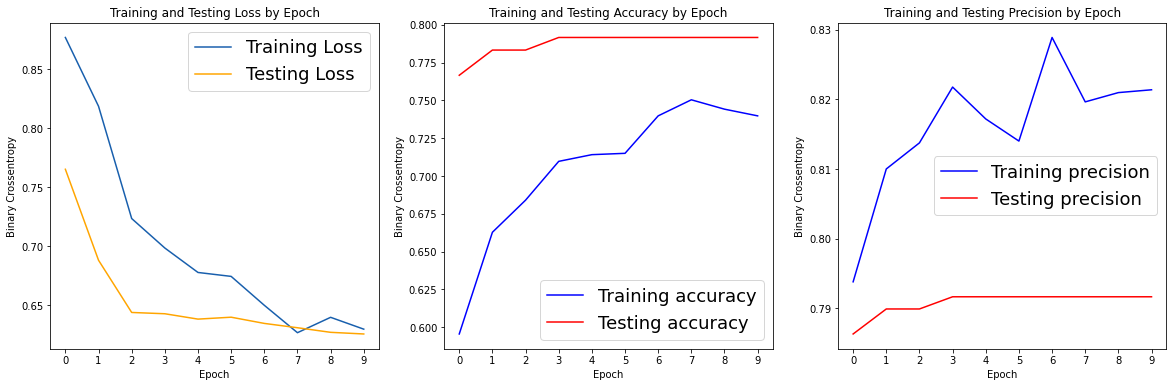

In [33]:
# coronal plane
num_epochs=10

cnn_model = build_model()
cor_ab_model, hst_cab = model_train(cnn_model, 'hst_cab', num_epochs, coronal_abnormal, coronal_abnormal_label, coronal_abnormal_val, coronal_abnormal_label_val)

# get/plot accuracy
hst_cab_acc=[]
hst_cab_acc.append(np.mean(hst_cab.history['val_accuracy']))
hst_cab_prec=[]
hst_cab_prec.append(np.mean(hst_cab.history['val_precision']))
plot_results(hst_cab)

Epoch 1/10
36/36 [==============================] - 3s 58ms/step - loss: 1.1196 - accuracy: 0.5230 - precision: 0.8258 - val_loss: 0.7288 - val_accuracy: 0.7917 - val_precision: 0.8017
Epoch 2/10
36/36 [==============================] - 2s 43ms/step - loss: 0.9045 - accuracy: 0.5770 - precision: 0.7935 - val_loss: 0.6571 - val_accuracy: 0.7750 - val_precision: 0.8091
Epoch 3/10
36/36 [==============================] - 2s 44ms/step - loss: 0.7676 - accuracy: 0.6133 - precision: 0.8190 - val_loss: 0.6393 - val_accuracy: 0.7833 - val_precision: 0.8000
Epoch 4/10
36/36 [==============================] - 2s 43ms/step - loss: 0.7414 - accuracy: 0.6451 - precision: 0.8208 - val_loss: 0.6328 - val_accuracy: 0.7833 - val_precision: 0.7949
Epoch 5/10
36/36 [==============================] - 2s 43ms/step - loss: 0.7326 - accuracy: 0.6496 - precision: 0.8285 - val_loss: 0.6334 - val_accuracy: 0.7833 - val_precision: 0.7949
Epoch 6/10
36/36 [==============================] - 2s 43ms/step - loss: 0.

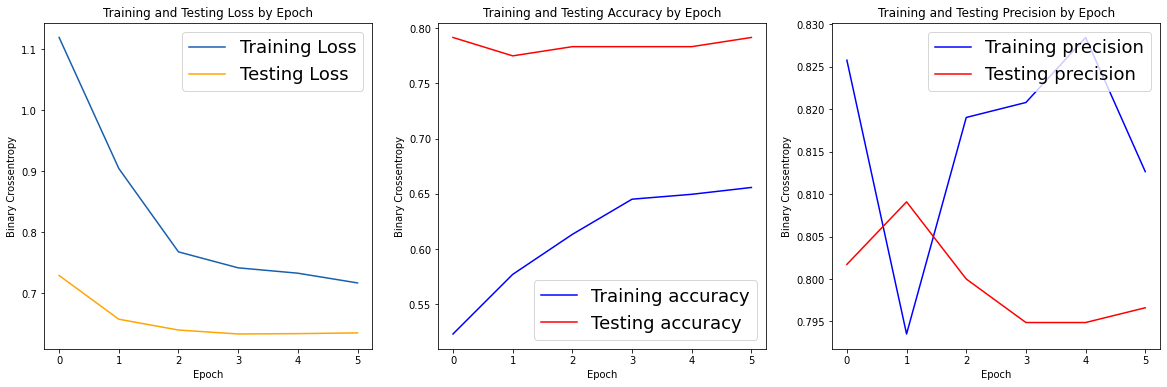

In [34]:
# axial plane
num_epochs=10

cnn_model = build_model()
axl_ab_model, hst_aab = model_train(cnn_model, 'hst_aab', num_epochs, axial_abnormal, axial_abnormal_label, axial_abnormal_val, axial_abnormal_label_val)

# get/plot accuracy
hst_aab_acc=[]
hst_aab_acc.append(np.mean(hst_aab.history['val_accuracy']))
hst_aab_prec=[]
hst_aab_prec.append(np.mean(hst_aab.history['val_precision']))
plot_results(hst_aab)

Epoch 1/10
36/36 [==============================] - 3s 56ms/step - loss: 1.2746 - accuracy: 0.4478 - precision: 0.8042 - val_loss: 0.6900 - val_accuracy: 0.7917 - val_precision: 0.7917
Epoch 2/10
36/36 [==============================] - 2s 42ms/step - loss: 0.9171 - accuracy: 0.5673 - precision: 0.8081 - val_loss: 0.6892 - val_accuracy: 0.8000 - val_precision: 0.7983
Epoch 3/10
36/36 [==============================] - 2s 43ms/step - loss: 0.8278 - accuracy: 0.6018 - precision: 0.8034 - val_loss: 0.6793 - val_accuracy: 0.7667 - val_precision: 0.7863
Epoch 4/10
36/36 [==============================] - 2s 43ms/step - loss: 0.7743 - accuracy: 0.6310 - precision: 0.8085 - val_loss: 0.6804 - val_accuracy: 0.7750 - val_precision: 0.7881
Epoch 5/10
36/36 [==============================] - 2s 43ms/step - loss: 0.7872 - accuracy: 0.6363 - precision: 0.8153 - val_loss: 0.6837 - val_accuracy: 0.7750 - val_precision: 0.7881


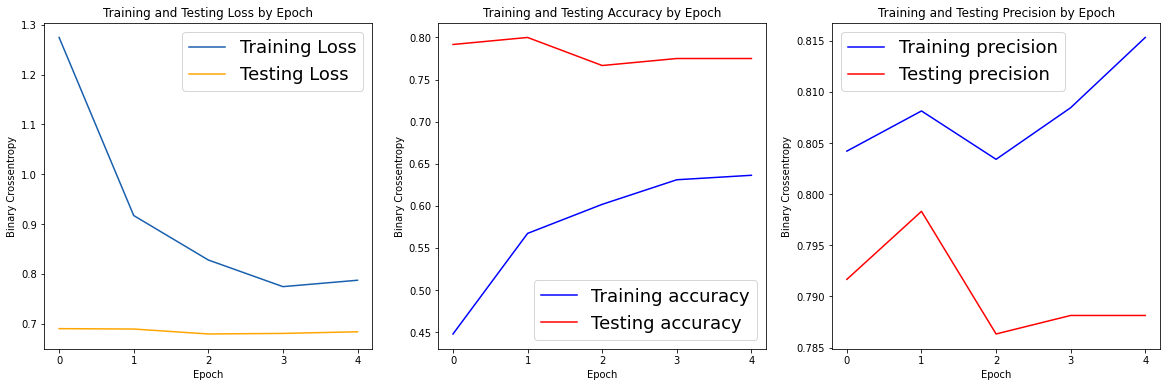

In [320]:
# sagittal plane
num_epochs=10

cnn_model = build_model()
sag_ab_model, hst_sab = model_train(cnn_model, 'hst_sab', num_epochs, sagittal_abnormal, sagittal_abnormal_label, sagittal_abnormal_val, sagittal_abnormal_label_val)

# get/plot accuracy
hst_sab_acc=[]
hst_sab_acc.append(np.mean(hst_sab.history['val_accuracy']))
hst_sab_prec=[]
hst_sab_prec.append(np.mean(hst_sab.history['val_precision']))
plot_results(hst_sab)

### training for meniscus dataset

Epoch 1/10
36/36 [==============================] - 3s 52ms/step - loss: 1.1040 - accuracy: 0.5009 - precision: 0.3587 - val_loss: 0.9188 - val_accuracy: 0.5500 - val_precision: 0.4375
Epoch 2/10
36/36 [==============================] - 2s 43ms/step - loss: 0.8975 - accuracy: 0.5416 - precision: 0.3484 - val_loss: 0.8225 - val_accuracy: 0.5417 - val_precision: 0.4483
Epoch 3/10
36/36 [==============================] - 2s 43ms/step - loss: 0.8395 - accuracy: 0.5690 - precision: 0.3858 - val_loss: 0.8053 - val_accuracy: 0.5833 - val_precision: 0.5385
Epoch 4/10
36/36 [==============================] - 2s 43ms/step - loss: 0.8142 - accuracy: 0.5584 - precision: 0.3797 - val_loss: 0.8027 - val_accuracy: 0.6000 - val_precision: 0.6250
Epoch 5/10
36/36 [==============================] - 2s 43ms/step - loss: 0.7975 - accuracy: 0.5796 - precision: 0.3952 - val_loss: 0.8037 - val_accuracy: 0.5583 - val_precision: 0.4667
Epoch 6/10
36/36 [==============================] - 2s 43ms/step - loss: 0.

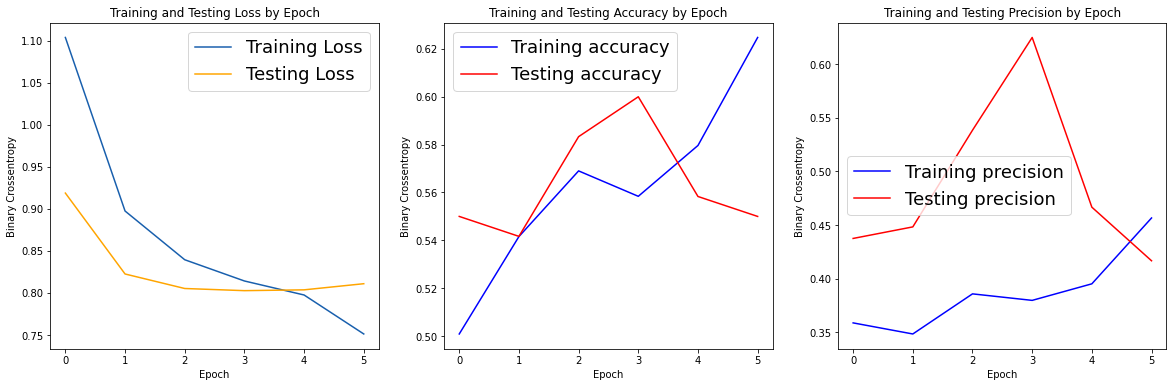

In [39]:
# coronal plane
num_epochs=10

cnn_model = build_model()
cor_men_model, hst_cmen = model_train(cnn_model, 'hst_cmen', num_epochs, coronal_mensicus, coronal_mensicus_label, coronal_mensicus_val, coronal_mensicus_label_val)

# get/plot accuracy
hst_cmen_acc=[]
hst_cmen_acc.append(np.mean(hst_cmen.history['val_accuracy']))
hst_cmen_prec=[]
hst_cmen_prec.append(np.mean(hst_cmen.history['val_precision']))
plot_results(hst_cmen)

Epoch 1/10
36/36 [==============================] - 3s 55ms/step - loss: 1.0942 - accuracy: 0.5531 - precision: 0.3594 - val_loss: 1.0461 - val_accuracy: 0.5667 - val_precision: 0.5000
Epoch 2/10
36/36 [==============================] - 2s 44ms/step - loss: 0.9172 - accuracy: 0.5381 - precision: 0.3589 - val_loss: 0.8186 - val_accuracy: 0.5500 - val_precision: 0.4545
Epoch 3/10
36/36 [==============================] - 2s 43ms/step - loss: 0.8201 - accuracy: 0.5796 - precision: 0.3866 - val_loss: 0.8054 - val_accuracy: 0.5750 - val_precision: 0.5385
Epoch 4/10
36/36 [==============================] - 2s 43ms/step - loss: 0.7803 - accuracy: 0.5885 - precision: 0.4017 - val_loss: 0.7837 - val_accuracy: 0.5417 - val_precision: 0.4348
Epoch 5/10
36/36 [==============================] - 2s 43ms/step - loss: 0.7915 - accuracy: 0.5805 - precision: 0.3890 - val_loss: 0.7740 - val_accuracy: 0.5750 - val_precision: 0.5238
Epoch 6/10
36/36 [==============================] - 2s 43ms/step - loss: 0.

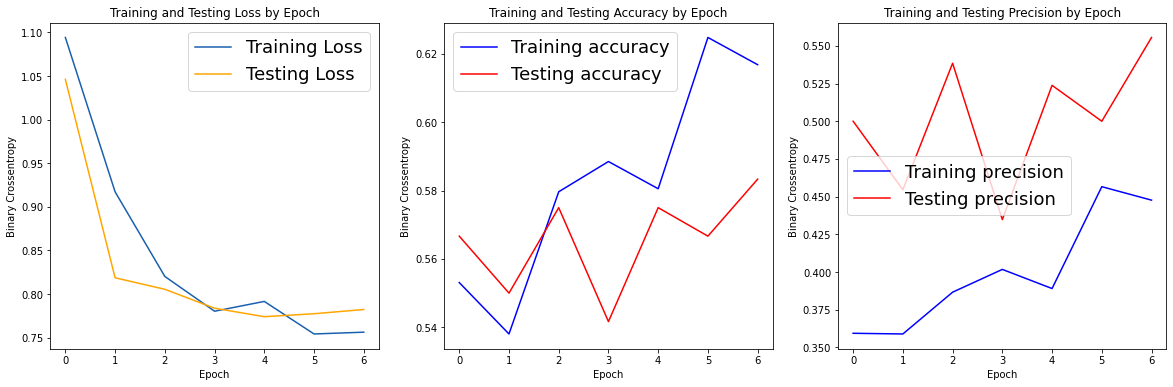

In [37]:
# axial plane
num_epochs=10

cnn_model = build_model()
axl_men_model, hst_amen = model_train(cnn_model, 'hst_amen', num_epochs, axial_mensicus, axial_mensicus_label, axial_mensicus_val, axial_mensicus_label_val)

# get/plot accuracy
hst_amen_acc=[]
hst_amen_acc.append(np.mean(hst_amen.history['val_accuracy']))
hst_amen_prec=[]
hst_amen_prec.append(np.mean(hst_amen.history['val_precision']))
plot_results(hst_amen)

Epoch 1/10
36/36 [==============================] - 3s 57ms/step - loss: 0.9862 - accuracy: 0.5097 - precision: 0.3616 - val_loss: 0.8761 - val_accuracy: 0.5750 - val_precision: 0.5556
Epoch 2/10
36/36 [==============================] - 2s 43ms/step - loss: 0.8842 - accuracy: 0.5584 - precision: 0.3762 - val_loss: 0.8177 - val_accuracy: 0.6083 - val_precision: 0.7778
Epoch 3/10
36/36 [==============================] - 2s 43ms/step - loss: 0.8562 - accuracy: 0.5593 - precision: 0.3569 - val_loss: 0.8014 - val_accuracy: 0.5833 - val_precision: 0.5833
Epoch 4/10
36/36 [==============================] - 2s 43ms/step - loss: 0.7961 - accuracy: 0.5982 - precision: 0.4164 - val_loss: 0.7922 - val_accuracy: 0.5750 - val_precision: 0.5333
Epoch 5/10
36/36 [==============================] - 2s 43ms/step - loss: 0.7859 - accuracy: 0.5708 - precision: 0.3771 - val_loss: 0.7872 - val_accuracy: 0.5583 - val_precision: 0.4706
Epoch 6/10
36/36 [==============================] - 2s 43ms/step - loss: 0.

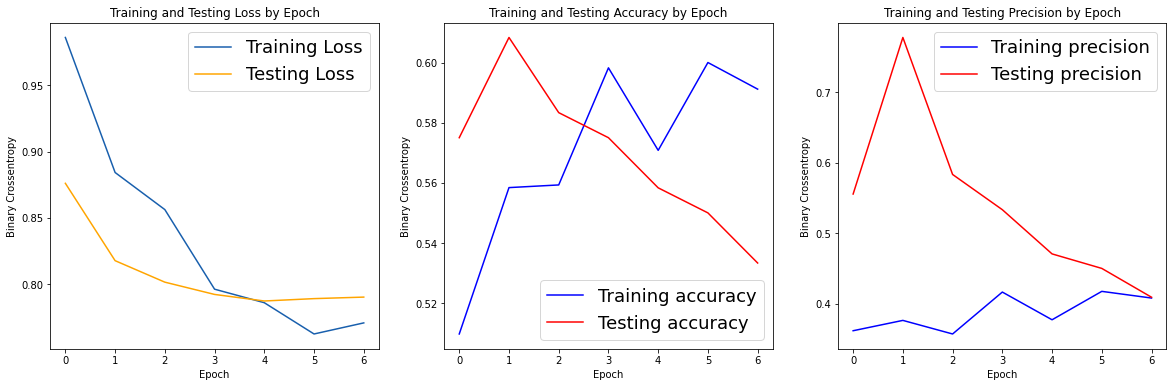

In [40]:
# sagittal plane
num_epochs=10

cnn_model = build_model()
sag_men_model, hst_smen = model_train(cnn_model, 'hst_smen', num_epochs, sagittal_mensicus, sagittal_mensicus_label, sagittal_mensicus_val, sagittal_mensicus_label_val)

# get/plot accuracy
hst_smen_acc=[]
hst_smen_acc.append(np.mean(hst_smen.history['val_accuracy']))
hst_smen_prec=[]
hst_smen_prec.append(np.mean(hst_smen.history['val_precision']))
plot_results(hst_smen)

### training for acl dataset

In [173]:
def build_acl_model():
    '''this function creates and builds the cnn model for the acl'''
    model = Sequential()
    
    model.add(Conv2D(filters=6, 
                     kernel_size=(5, 5),
                     activation='relu',
                     padding='same',
                    #  kernel_regularizer=l2(1e-3),
                     input_shape=(256,256,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),
                              strides=(2,2)))

    model.add(Conv2D(filters=16, 
                     kernel_size=(5, 5), 
                     activation='relu',))
                    #  kernel_regularizer=l2(1e-3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),
                              strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(32, activation='relu'
                    ,kernel_regularizer=l2(1e-3)
                   ))
    model.add(Dropout(0.7))
    
    model.add(Dense(16, activation='relu',
                    kernel_regularizer=l2(1e-3)
                   ))
    model.add(Dropout(0.7))
    model.add(Dense(1, activation='sigmoid'))
    
    sgd = optimizers.SGD(learning_rate=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision')])
    
    return model

Epoch 1/10
36/36 [==============================] - 3s 61ms/step - loss: 1.6619 - accuracy: 0.5265 - precision: 0.1643 - val_loss: 0.8181 - val_accuracy: 0.5500 - val_precision: 0.5000
Epoch 2/10
36/36 [==============================] - 2s 49ms/step - loss: 1.1447 - accuracy: 0.5814 - precision: 0.1807 - val_loss: 0.7911 - val_accuracy: 0.5583 - val_precision: 0.5333
Epoch 3/10
36/36 [==============================] - 2s 48ms/step - loss: 1.0235 - accuracy: 0.5602 - precision: 0.1616 - val_loss: 0.7870 - val_accuracy: 0.5417 - val_precision: 0.4762
Epoch 4/10
36/36 [==============================] - 2s 49ms/step - loss: 0.8655 - accuracy: 0.6584 - precision: 0.2287 - val_loss: 0.7855 - val_accuracy: 0.5500 - val_precision: 0.5000
Epoch 5/10
36/36 [==============================] - 2s 49ms/step - loss: 0.8622 - accuracy: 0.6195 - precision: 0.1696 - val_loss: 0.7809 - val_accuracy: 0.5583 - val_precision: 0.5263
Epoch 6/10
36/36 [==============================] - 2s 49ms/step - loss: 0.

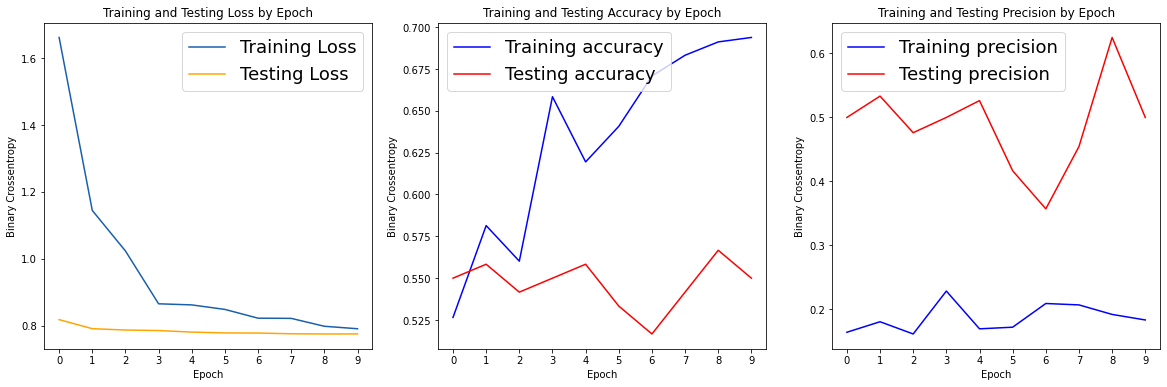

In [244]:
# coronal plane
num_epochs=10

acl_model = build_acl_model()
cor_acl_model, hst_cacl = model_train(acl_model, 'hst_cacl', num_epochs, coronal_acl, coronal_acl_label, coronal_acl_val, coronal_acl_label_val)

# get/plot accuracy
hst_cacl_acc=[]
hst_cacl_acc.append(np.mean(hst_cacl.history['val_accuracy']))
hst_cacl_prec=[]
hst_cacl_prec.append(np.mean(hst_cacl.history['val_precision']))
plot_results(hst_cacl)

Epoch 1/10
36/36 [==============================] - 3s 61ms/step - loss: 2.2043 - accuracy: 0.4319 - precision: 0.1827 - val_loss: 0.8286 - val_accuracy: 0.4417 - val_precision: 0.3968
Epoch 2/10
36/36 [==============================] - 2s 48ms/step - loss: 1.1407 - accuracy: 0.5593 - precision: 0.1915 - val_loss: 0.8048 - val_accuracy: 0.4750 - val_precision: 0.4483
Epoch 3/10
36/36 [==============================] - 2s 51ms/step - loss: 0.9412 - accuracy: 0.6469 - precision: 0.1741 - val_loss: 0.7943 - val_accuracy: 0.5250 - val_precision: 0.4717
Epoch 4/10
36/36 [==============================] - 2s 48ms/step - loss: 0.8538 - accuracy: 0.7248 - precision: 0.2023 - val_loss: 0.7946 - val_accuracy: 0.5500 - val_precision: 0.5000
Epoch 5/10
36/36 [==============================] - 2s 49ms/step - loss: 0.8151 - accuracy: 0.7496 - precision: 0.2047 - val_loss: 0.7945 - val_accuracy: 0.5417 - val_precision: 0.4857


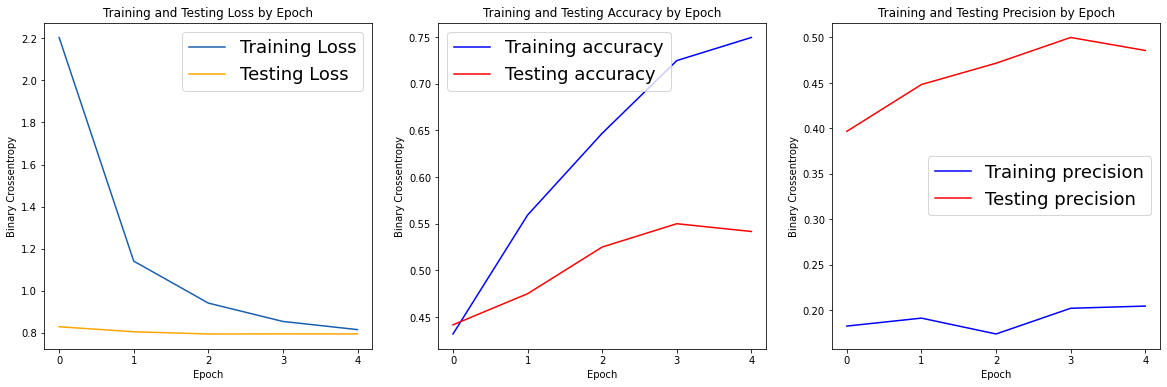

In [245]:
# axial plane
num_epochs=10

acl_model = build_acl_model()
axl_acl_model, hst_aacl = model_train(acl_model, 'hst_aacl', num_epochs, axial_acl, axial_acl_label, axial_acl_val, axial_acl_label_val)

# get/plot accuracy
hst_aacl_acc=[]
hst_aacl_acc.append(np.mean(hst_aacl.history['val_accuracy']))
hst_aacl_prec=[]
hst_aacl_prec.append(np.mean(hst_aacl.history['val_precision']))
plot_results(hst_aacl)

Epoch 1/10
36/36 [==============================] - 3s 59ms/step - loss: 1.4892 - accuracy: 0.6027 - precision: 0.2151 - val_loss: 1.1766 - val_accuracy: 0.5500 - val_precision: 0.0000e+00
Epoch 2/10
36/36 [==============================] - 2s 48ms/step - loss: 0.9835 - accuracy: 0.6248 - precision: 0.1860 - val_loss: 0.8251 - val_accuracy: 0.5500 - val_precision: 0.5000
Epoch 3/10
36/36 [==============================] - 2s 50ms/step - loss: 0.9081 - accuracy: 0.6496 - precision: 0.1987 - val_loss: 0.7856 - val_accuracy: 0.5500 - val_precision: 0.5000
Epoch 4/10
36/36 [==============================] - 2s 49ms/step - loss: 0.8489 - accuracy: 0.7018 - precision: 0.2232 - val_loss: 0.7793 - val_accuracy: 0.5417 - val_precision: 0.4286
Epoch 5/10
36/36 [==============================] - 2s 51ms/step - loss: 0.8053 - accuracy: 0.7115 - precision: 0.1895 - val_loss: 0.7900 - val_accuracy: 0.5500 - val_precision: 0.5000
Epoch 6/10
36/36 [==============================] - 2s 48ms/step - loss

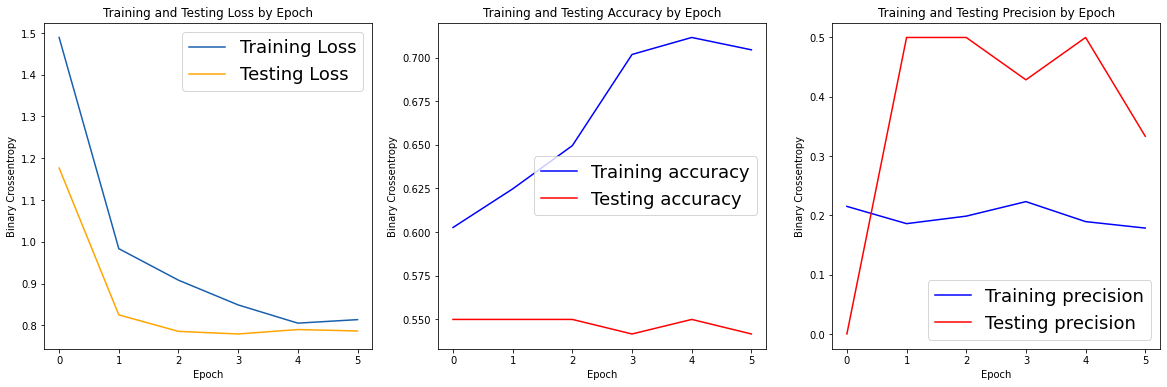

In [248]:
# sagittal plane
num_epochs=10

acl_model = build_acl_model()
sag_acl_model, hst_sacl = model_train(acl_model, 'hst_sacl', num_epochs, sagittal_acl, sagittal_acl_label, sagittal_acl_val, sagittal_acl_label_val)

# get/plot accuracy
hst_sacl_acc=[]
hst_sacl_acc.append(np.mean(hst_sacl.history['val_accuracy']))
hst_sacl_prec=[]
hst_sacl_prec.append(np.mean(hst_sacl.history['val_precision']))
plot_results(hst_sacl)

The graphs so far are far from perfect, but it is a big improvement on the overtraining seen in other models.

**preview of average accuracy**

In [321]:
[hst_cmen_acc, hst_amen_acc, hst_smen_acc]

[[0.5638888974984487], [0.5654761876378741], [0.5690476213182721]]

In [322]:
[hst_cab_acc, hst_aab_acc, hst_sab_acc]

[[0.7875000178813935], [0.784722238779068], [0.7816666603088379]]

In [323]:
[hst_cacl_acc, hst_aacl_acc, hst_sacl_acc]

[[0.5466666758060456], [0.5066666662693023], [0.5472222367922465]]

**preview of average precision**

In [324]:
[hst_cmen_prec, hst_amen_prec, hst_smen_prec]

[[0.4887617925802867], [0.5010221089635577], [0.5399541684559414]]

In [325]:
[hst_cab_prec, hst_aab_prec, hst_sab_prec]

[[0.790782356262207], [0.7995281418164571], [0.7905164003372193]]

In [326]:
[hst_cacl_prec, hst_aacl_prec, hst_sacl_prec]

[[0.48891946375370027], [0.46050273180007933], [0.3769841293493907]]

## Evaluate results

### abnormal dataset


In [327]:
cmen_scores = cor_ab_model.evaluate(coronal_abnormal_val, np.array(coronal_abnormal_label_val), verbose=0)
print('Test loss:', cmen_scores[0]) 
print('Test accuracy:', cmen_scores[1])

Test loss: 0.6257044672966003
Test accuracy: 0.7916666865348816


In [328]:
amen_scores = axl_ab_model.evaluate(axial_abnormal_val, np.array(axial_abnormal_label_val), verbose=0)
print('Test loss:', amen_scores[0]) 
print('Test accuracy:', amen_scores[1])

Test loss: 0.6346226930618286
Test accuracy: 0.7916666865348816


In [329]:
smen_scores = sag_ab_model.evaluate(sagittal_abnormal_val, np.array(sagittal_abnormal_label_val), verbose=0)
print('Test loss:', smen_scores[0]) 
print('Test accuracy:', smen_scores[1])

Test loss: 0.6837071776390076
Test accuracy: 0.7749999761581421


**Evaluate predictions for training set**


In [330]:
path_dir = '/content/drive/MyDrive' 
saved_cor_model = load_model(f'{path_dir}/hst_cab/own_model.h5')
cor_pred = saved_cor_model.predict(coronal_abnormal) 

In [331]:
saved_axl_model = load_model(f'{path_dir}/hst_aab/own_model.h5')
axl_pred = saved_axl_model.predict(axial_abnormal) 

In [332]:
saved_sag_model = load_model(f'{path_dir}/hst_sab/own_model.h5')
sag_pred = saved_sag_model.predict(sagittal_abnormal) 

In [333]:
pred_ab = pd.DataFrame(np.column_stack([cor_pred,axl_pred,sag_pred]),columns=['cor_pred', 'axl_pred', 'sag_pred'])
pred_ab['mean'] = pred_ab.mean(axis=1)

In [334]:
# since model output is [0,1] using sigmoid activation function
# pred is the probability
# take average probability from all 3 planes
# if prob<0.5, it is 0.
pred_ab['predict'] = pred_ab['mean'].map(lambda x: 0 if x<0.5 else 1)
pred_ab['predict'].value_counts()

1    1130
Name: predict, dtype: int64

In [335]:
pred_ab['true'] = coronal_abnormal_label
pred_ab[pred_ab['true'] != pred_ab['predict']].shape

(217, 6)

In [336]:
pred_ab[pred_ab['true'] != pred_ab['predict']]

,cor_pred,axl_pred,sag_pred,mean,predict,true
11,0.665911,0.512065,0.816565,0.664847,1,0
12,0.663982,0.613951,0.696787,0.658240,1,0
14,0.840951,0.868039,0.713584,0.807524,1,0
17,0.459520,0.830662,0.846255,0.712146,1,0
21,0.776803,0.507412,0.806674,0.696963,1,0
...,...,...,...,...,...,...
1093,0.690159,0.876202,0.852858,0.806406,1,0
1115,0.732041,0.652566,0.713179,0.699262,1,0
1119,0.581006,0.770026,0.779980,0.710337,1,0
1123,0.640428,0.748426,0.696835,0.695230,1,0


**Evaluate predictions for validation set**


In [337]:
path_dir = '/content/drive/MyDrive' 
saved_cor_model = load_model(f'{path_dir}/hst_cab/own_model.h5')
cor_pred_val = saved_cor_model.predict(coronal_abnormal_val) 

In [338]:
saved_axl_model = load_model(f'{path_dir}/hst_aab/own_model.h5')
axl_pred_val = saved_axl_model.predict(axial_abnormal_val) 

In [339]:
saved_sag_model = load_model(f'{path_dir}/hst_sab/own_model.h5')
sag_pred_val = saved_sag_model.predict(sagittal_abnormal_val) 

In [340]:
pred_ab_val = pd.DataFrame(np.column_stack([cor_pred_val,axl_pred_val,sag_pred_val]),columns=['cor_pred_val', 'axl_pred_val', 'sag_pred_val'])
pred_ab_val['mean'] = pred_ab_val.mean(axis=1)

In [341]:
# since model output is [0,1] using sigmoid activation function
# pred is the probability
# take average probability from all 3 planes
# if prob<0.5, it is 0.
pred_ab_val['predict'] = pred_ab_val['mean'].map(lambda x: 0 if x<0.5 else 1)
pred_ab_val['predict'].value_counts()

1    120
Name: predict, dtype: int64

In [342]:
pred_ab_val['true'] = coronal_abnormal_label_val
pred_ab_val[pred_ab_val['true'] != pred_ab_val['predict']].shape

(25, 6)

In [343]:
pred_ab_val[pred_ab_val['true'] != pred_ab_val['predict']]

,cor_pred_val,axl_pred_val,sag_pred_val,mean,predict,true
0,0.921336,0.812739,0.931815,0.888630,1,0
1,0.632172,0.578608,0.832905,0.681228,1,0
2,0.664182,0.909573,0.910063,0.827939,1,0
3,0.753537,0.717968,0.872439,0.781315,1,0
4,0.886644,0.812536,0.682024,0.793735,1,0
5,0.765801,0.770336,0.838664,0.791600,1,0
6,0.819216,0.691907,0.941787,0.817637,1,0
7,0.729358,0.764596,0.712832,0.735595,1,0
8,0.795267,0.824279,0.597439,0.738995,1,0
9,0.666353,0.615396,0.810749,0.697499,1,0


### meniscus dataset

In [344]:
cmen_scores = cor_men_model.evaluate(coronal_mensicus_val, np.array(coronal_mensicus_label_val), verbose=0)
print('Test loss:', cmen_scores[0]) 
print('Test accuracy:', cmen_scores[1])

Test loss: 0.8109723329544067
Test accuracy: 0.550000011920929


In [345]:
amen_scores = axl_men_model.evaluate(axial_mensicus_val, np.array(axial_mensicus_label_val), verbose=0)
print('Test loss:', amen_scores[0]) 
print('Test accuracy:', amen_scores[1])

Test loss: 0.7822489142417908
Test accuracy: 0.5833333134651184


In [346]:
smen_scores = sag_men_model.evaluate(sagittal_mensicus_val, np.array(sagittal_mensicus_label_val), verbose=0)
print('Test loss:', smen_scores[0]) 
print('Test accuracy:', smen_scores[1])

Test loss: 0.7901632785797119
Test accuracy: 0.5333333611488342


**Evaluate predictions for training set**


In [347]:
path_dir = '/content/drive/MyDrive' 
saved_cor_model = load_model(f'{path_dir}/hst_cmen/own_model.h5')
cor_pred = saved_cor_model.predict(coronal_mensicus) 

In [348]:
saved_axl_model = load_model(f'{path_dir}/hst_amen/own_model.h5')
axl_pred = saved_axl_model.predict(axial_mensicus) 

In [349]:
saved_sag_model = load_model(f'{path_dir}/hst_smen/own_model.h5')
sag_pred = saved_sag_model.predict(sagittal_mensicus) 

In [350]:
pred_men = pd.DataFrame(np.column_stack([cor_pred,axl_pred,sag_pred]),columns=['cor_pred', 'axl_pred', 'sag_pred'])
pred_men['mean'] = pred_men.mean(axis=1)

In [351]:
# since model output is [0,1] using sigmoid activation function
# pred is the probability
# take average probability from all 3 planes
pred_men['mean']

0       0.376208
1       0.397293
2       0.408609
3       0.444132
4       0.391884
          ...   
1125    0.388979
1126    0.456321
1127    0.342435
1128    0.525846
1129    0.409938
Name: mean, Length: 1130, dtype: float32

In [352]:
# if prob<0.5, it is 0.
pred_men['predict'] = pred_men['mean'].map(lambda x: 0 if x<0.5 else 1)

In [353]:
pred_men['predict'].value_counts()

0    1092
1      38
Name: predict, dtype: int64

In [354]:
# labels are same for all planes
pred_men['true'] = coronal_mensicus_label

In [355]:
pred_men[pred_men['true'] != pred_men['predict']].shape

(377, 6)

In [356]:
pred_men[pred_men['true'] != pred_men['predict']]

,cor_pred,axl_pred,sag_pred,mean,predict,true
1,0.329627,0.453888,0.408365,0.397293,0,1
3,0.381990,0.511086,0.439321,0.444132,0,1
5,0.393064,0.393792,0.515687,0.434181,0,1
10,0.369043,0.438375,0.219692,0.342370,0,1
16,0.398974,0.321442,0.410408,0.376941,0,1
...,...,...,...,...,...,...
1117,0.359111,0.557183,0.426363,0.447552,0,1
1120,0.446579,0.372062,0.433497,0.417379,0,1
1125,0.292885,0.417270,0.456781,0.388979,0,1
1126,0.465835,0.446374,0.456755,0.456321,0,1


**Evaluate predictions for validation set**


In [357]:
path_dir = '/content/drive/MyDrive' 
saved_cor_model = load_model(f'{path_dir}/hst_cmen/own_model.h5')
cor_pred_val = saved_cor_model.predict(coronal_mensicus_val) 

In [358]:
saved_axl_model = load_model(f'{path_dir}/hst_amen/own_model.h5')
axl_pred_val = saved_axl_model.predict(axial_mensicus_val) 

In [359]:
saved_sag_model = load_model(f'{path_dir}/hst_smen/own_model.h5')
sag_pred_val = saved_sag_model.predict(sagittal_mensicus_val) 

In [360]:
pred_men_val = pd.DataFrame(np.column_stack([cor_pred_val,axl_pred_val,sag_pred_val]),columns=['cor_pred_val', 'axl_pred_val', 'sag_pred_val'])
pred_men_val['mean'] = pred_men_val.mean(axis=1)

In [361]:
# since model output is [0,1] using sigmoid activation function
# pred is the probability
# take average probability from all 3 planes
pred_men_val['mean']

0      0.437389
1      0.371582
2      0.445843
3      0.353414
4      0.353025
         ...   
115    0.442138
116    0.316581
117    0.488384
118    0.430250
119    0.380389
Name: mean, Length: 120, dtype: float32

In [362]:
# if prob<0.5, it is 0.
pred_men_val['predict'] = pred_men_val['mean'].map(lambda x: 0 if x<0.5 else 1)

In [363]:
pred_men_val['predict'].value_counts()

0    114
1      6
Name: predict, dtype: int64

In [364]:
# labels are same for all planes
pred_men_val['true'] = coronal_mensicus_label_val

In [365]:
pred_men_val[pred_men_val['true'] != pred_men_val['predict']].shape

(50, 6)

In [366]:
pred_men_val[pred_men_val['true'] != pred_men_val['predict']]

,cor_pred_val,axl_pred_val,sag_pred_val,mean,predict,true
16,0.610428,0.480037,0.441692,0.510719,1,0
30,0.410186,0.726634,0.464250,0.533690,1,0
42,0.431465,0.489183,0.443747,0.454798,0,1
44,0.462029,0.456270,0.469403,0.462567,0,1
54,0.474834,0.357529,0.533147,0.455170,0,1
56,0.280696,0.453592,0.449612,0.394633,0,1
58,0.284273,0.466580,0.438584,0.396479,0,1
61,0.448308,0.387276,0.443480,0.426355,0,1
62,0.466381,0.548923,0.460342,0.491882,0,1
64,0.402800,0.401667,0.368679,0.391049,0,1


### acl dataset

In [367]:
cmen_scores = cor_acl_model.evaluate(coronal_acl_val, np.array(coronal_acl_label_val), verbose=0)
print('Test loss:', cmen_scores[0]) 
print('Test accuracy:', cmen_scores[1])

Test loss: 0.7753735780715942
Test accuracy: 0.550000011920929


In [368]:
amen_scores = axl_acl_model.evaluate(axial_acl_val, np.array(axial_acl_label_val), verbose=0)
print('Test loss:', amen_scores[0]) 
print('Test accuracy:', amen_scores[1])

Test loss: 0.7945320010185242
Test accuracy: 0.5416666865348816


In [369]:
smen_scores = sag_acl_model.evaluate(sagittal_acl_val, np.array(sagittal_acl_label_val), verbose=0)
print('Test loss:', smen_scores[0]) 
print('Test accuracy:', smen_scores[1])

Test loss: 0.7865368127822876
Test accuracy: 0.5416666865348816


**Evaluate predictions for training set**


In [370]:
path_dir = '/content/drive/MyDrive' 
saved_cor_model = load_model(f'{path_dir}/hst_cacl/own_model.h5')
cor_pred = saved_cor_model.predict(coronal_acl) 

In [371]:
saved_axl_model = load_model(f'{path_dir}/hst_aacl/own_model.h5')
axl_pred = saved_axl_model.predict(axial_acl) 

In [372]:
saved_sag_model = load_model(f'{path_dir}/hst_sacl/own_model.h5')
sag_pred = saved_sag_model.predict(sagittal_acl) 

In [373]:
pred_acl = pd.DataFrame(np.column_stack([cor_pred,axl_pred,sag_pred]),columns=['cor_pred', 'axl_pred', 'sag_pred'])
pred_acl['mean'] = pred_acl.mean(axis=1)

In [374]:
# if prob<0.5, it is 0.
pred_acl['predict'] = pred_acl['mean'].map(lambda x: 0 if x<0.5 else 1)
pred_acl['predict'].value_counts()

0    1059
1      71
Name: predict, dtype: int64

In [375]:
pred_acl['true'] = coronal_acl_label
pred_acl[pred_acl['true'] != pred_acl['predict']].shape

(225, 6)

In [376]:
pred_acl[pred_acl['true'] != pred_acl['predict']]

,cor_pred,axl_pred,sag_pred,mean,predict,true
1,0.393826,0.502843,0.499251,0.465307,0,1
18,0.429946,0.520214,0.379670,0.443277,0,1
37,0.499775,0.539369,0.452428,0.497191,0,1
49,0.490344,0.552800,0.452895,0.498680,0,1
59,0.468308,0.498792,0.497866,0.488322,0,1
...,...,...,...,...,...,...
1096,0.501467,0.498792,0.293651,0.431303,0,1
1101,0.413301,0.500794,0.498893,0.470996,0,1
1107,0.395725,0.496709,0.498893,0.463776,0,1
1117,0.456510,0.498829,0.498893,0.484744,0,1


**Evaluate predictions for validation set**


In [377]:
path_dir = '/content/drive/MyDrive' 
saved_cor_model = load_model(f'{path_dir}/hst_cacl/own_model.h5')
cor_pred_val = saved_cor_model.predict(coronal_acl_val) 

In [378]:
saved_axl_model = load_model(f'{path_dir}/hst_aacl/own_model.h5')
axl_pred_val = saved_axl_model.predict(axial_acl_val) 

In [379]:
saved_sag_model = load_model(f'{path_dir}/hst_sacl/own_model.h5')
sag_pred_val = saved_sag_model.predict(sagittal_acl_val) 

In [380]:
pred_acl_val = pd.DataFrame(np.column_stack([cor_pred_val,axl_pred_val,sag_pred_val]),columns=['cor_pred_val', 'axl_pred_val', 'sag_pred_val'])
pred_acl_val['mean'] = pred_acl_val.mean(axis=1)

In [381]:
# if prob<0.5, it is 0.
pred_acl_val['predict'] = pred_acl_val['mean'].map(lambda x: 0 if x<0.5 else 1)
pred_acl_val['predict'].value_counts()

0    110
1     10
Name: predict, dtype: int64

In [382]:
pred_acl_val['true'] = coronal_acl_label_val
pred_acl_val[pred_acl_val['true'] != pred_acl_val['predict']].shape

(52, 6)

In [383]:
pred_acl_val[pred_acl_val['true'] != pred_acl_val['predict']]

,cor_pred_val,axl_pred_val,sag_pred_val,mean,predict,true
20,0.535579,0.506693,0.464181,0.502151,1,0
24,0.476249,0.526669,0.515798,0.506239,1,0
42,0.435048,0.475693,0.256603,0.389114,0,1
43,0.493931,0.498792,0.463212,0.485312,0,1
45,0.448550,0.498792,0.342222,0.429855,0,1
46,0.493643,0.498792,0.464726,0.485720,0,1
47,0.470216,0.509031,0.354510,0.444586,0,1
48,0.497258,0.498792,0.402839,0.466296,0,1
49,0.482254,0.498772,0.371527,0.450851,0,1
51,0.213883,0.498792,0.444315,0.385663,0,1


**export results to csv**

In [384]:
pred_ab.to_csv('/content/drive/MyDrive/oneown_pred_ab_results.csv')
pred_acl.to_csv('/content/drive/MyDrive/oneown_pred_acl_results.csv')
pred_men.to_csv('/content/drive/MyDrive/oneown_pred_men_results.csv')

In [385]:
pred_ab_val.to_csv('/content/drive/MyDrive/oneown_pred_val_ab_results.csv')
pred_acl_val.to_csv('/content/drive/MyDrive/oneown_pred_val_acl_results.csv')
pred_men_val.to_csv('/content/drive/MyDrive/oneown_pred_val_men_results.csv')